In [1]:
import json
import os
from time import time

import firecrawl
import matplotlib.pyplot as plt
import nest_asyncio
import pandas as pd
import requests
import seaborn as sns
import tiktoken
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from litellm import completion
from markdownify import MarkdownConverter
from playwright.async_api import async_playwright
from pydantic import BaseModel, Field
from recipe_scrapers import scrape_html
from scrapegraphai.graphs import SmartScraperGraph

nest_asyncio.apply()
load_dotenv()

True

## Setup

In [2]:
tokenizer = tiktoken.encoding_for_model("gpt-4o")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL")
FIRECRAWL_API_KEY = os.getenv("FIRECRAWL_API_KEY")

In [3]:
recipe_urls = [
    "https://www.bbcgoodfood.com/recipes/vegan-carbonara",
    "https://www.bbcgoodfood.com/recipes/juicy-lucy-burgers-stuffed-with-cheese-pickle",
    "https://www.allrecipes.com/recipe/9111/cranberry-sauce/",
    "https://www.allrecipes.com/recipe/19547/grandmas-corn-bread-dressing/",
    "https://www.delish.com/cooking/recipe-ideas/a62098456/million-dollar-mac-and-cheese-recipe/",
    "https://www.delish.com/cooking/recipe-ideas/a49569/melting-potatoes-recipe/",
    "https://www.seriouseats.com/pear-salad-recipe-8746365",
    "https://www.seriouseats.com/charred-asparagus-with-miso-bearnaise-sauce",
]

responses = []

## Response model

In [ ]:
class Recipe(BaseModel):
    title: str = Field(
        None, description="Name of the recipe", example="Classic Chocolate Chip Cookies"
    )
    ingredients: list[str] = Field(
        ...,
        description="List of all ingredients needed for the recipe, including optional garnishes",
    )
    instructions: list[str] = Field(
        ..., description="Step-by-step preparation instructions in chronological order"
    )

## LLM as Extraction engine

In [ ]:
def extract(text: str) -> dict:
    prompt = f"Extract the recipe from the following text: {text}"
    try:
        response = completion(
            model="gpt-4o-mini",
            base_url=OPENAI_BASE_URL,
            api_key=OPENAI_API_KEY,
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            response_format=Recipe,
        )
        return response
    except Exception as e:
        print(e)
        raise ValueError(f"Failed to extract from html: {e}")

## Method 0 : Recipe Scrapers (baseline)

In [6]:
def method_0(url: str) -> dict:
    # method 0 : recipe_scrapers
    html = requests.get(url, headers={"User-Agent": "Burger Seeker Richard"}).content
    recipe = scrape_html(html, org_url=url)
    return recipe

In [7]:
for url in recipe_urls:
    start = time()
    recipe = method_0(url)
    end = time()

    output_tokens = tokenizer.encode(
        f"{recipe.title() + ' ' + ",".join(recipe.ingredients()) + ' ' + ",".join(recipe.instructions())}"
    )
    response = {
        "title": recipe.title(),
        "ingredients": recipe.ingredients(),
        "instructions": recipe.instructions().split("\n"),
        "method": "recipe_scrapers",
        "input_tokens": 0,
        "output_tokens": len(output_tokens),
        "time": end - start,
    }
    responses.append(response)

## Method 1 : Beautifulsoup + Playwright

In [8]:
async def method_1(url: str, markdown: bool = False) -> BeautifulSoup:
    # Method 1 : Beautifulsoup + Playwright
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()

        # TODO : generate new headers

        page = await context.new_page()

        # TODO : Add random scraping timeout and wait_until (sleep)

        await page.goto(url, timeout=60000, wait_until="networkidle")
        content = await page.content()

        # TODO Save all content + update db

        soup = BeautifulSoup(content, "html.parser")
        await browser.close()

    return MarkdownConverter().convert_soup(soup) if markdown else soup.text

## Method 2 : Jina AI Reader

In [9]:
def method_2(url: str) -> str:
    return requests.get(f"https://r.jina.ai/{url}").text

## Method 3 : Firecrawl

In [10]:
def method_3(url: str) -> str:
    app = firecrawl.FirecrawlApp(api_key=FIRECRAWL_API_KEY)
    scraped_data = app.scrape_url(url)["markdown"]
    return scraped_data

## Method 4 : ScrapeGraphAI

In [ ]:
def method_4(url: str) -> dict:

    graph_config = {
        "llm": {
            "model": "openai/gpt-4o-mini",
            "api_key": OPENAI_API_KEY,
            "base_url": OPENAI_BASE_URL,
        },
        "timeout": 60000,
        "verbose": False,
        "headless": True,
        "cache": False,
    }

    smart_scraper_graph = SmartScraperGraph(
        prompt=f"Extract recipe from the following URL in this schema {json.dumps(Recipe.schema())}",
        source=url,
        config=graph_config,
    )
    result = smart_scraper_graph.run()

    return result

In [12]:
for url in recipe_urls:
    start = time()
    recipe = method_4(url)
    end = time()

    response = {
        "title": recipe["title"],
        "ingredients": recipe["ingredients"],
        "instructions": recipe["instructions"],
        "method": "ScrapeGraphAI",
        "input_tokens": 0,
        "output_tokens": 0,
        "time": end - start,
    }
    responses.append(response)

## Scrape with each method

In [13]:
func_map = {
    "Beautifulsoup + Playwright": method_1,
    "Beautifulsoup + Playwright md": method_1,
    "Jina AI Reader": method_2,
    "Firecrawl": method_3,
}

for method, func in func_map.items():
    for url in recipe_urls:
        start = time()
        if "Beautifulsoup + Playwright" in method:
            recipe_markdown = (
                await func(url, markdown=True) if "md" in method else await func(url)
            )
        else:
            recipe_markdown = func(url)
        llm_response = extract(recipe_markdown)
        recipe = Recipe.model_validate_json(llm_response.choices[0].message.content)

        end = time()

        input_tokens = llm_response.usage.prompt_tokens
        output_tokens = llm_response.usage.completion_tokens
        response = {
            "title": recipe.title,
            "ingredients": recipe.ingredients,
            "instructions": recipe.instructions,
            "method": method,
            "input_tokens": input_tokens,
            "output_tokens": output_tokens,
            "time": end - start,
        }
        responses.append(response)

## Evaluation

In [3]:
# df = pd.DataFrame(responses)
# df.to_csv("recipes.csv", index=False)
df = pd.read_csv("recipes.csv")

In [4]:
def format_recipe_method(df: pd.DataFrame, index : int = 1) -> str:
    formatted_output = "Recipe Methods Overview\n" + "=" * 50 + "\n\n"

    for method in df["method"].unique():
        # Get the first recipe for each method
        recipe = df[df["method"] == method][
            ["method", "title", "ingredients", "instructions"]
        ].values[index]

        formatted_output += f"""
📍 {recipe[0].upper()}
------------------
🏷️ Title: {recipe[1]}
🥘 Ingredients: {recipe[2][:100]}... {len(recipe[2])}
📝 Instructions: {recipe[3][:100]}... {len(recipe[3])}

"""

    return formatted_output

In [5]:
print(format_recipe_method(df, 1))

Recipe Methods Overview


📍 RECIPE_SCRAPERS
------------------
🏷️ Title: Juicy Lucy burgers stuffed with cheese & pickle
🥘 Ingredients: ['500g 15% fat beef mince', "1 tbsp all-purpose seasoning (we used Dunn's River)", '6-8 cheese slice... 287
📝 Instructions: ['Put the beef mince and all-purpose seasoning in a large bowl and season with salt and pepper. Mix ... 1052


📍 SCRAPEGRAPHAI
------------------
🏷️ Title: Juicy Lucy burgers stuffed with cheese & pickle
🥘 Ingredients: ['500g 15% fat beef mince', "1 tbsp all-purpose seasoning (we used Dunn's River)", '6-8 cheese slice... 283
📝 Instructions: ['Put the beef mince and all-purpose seasoning in a large bowl and season with salt and pepper. Mix ... 1052


📍 BEAUTIFULSOUP + PLAYWRIGHT
------------------
🏷️ Title: Juicy Lucy Burgers Stuffed with Cheese & Pickle
🥘 Ingredients: ['500g 15% fat beef mince', "1 tbsp all-purpose seasoning (e.g., Dunn's River)", '6-8 cheese slices,... 288
📝 Instructions: ['Put the beef mince and all-purpose seas

In [6]:
summary = df[['method', 'input_tokens', 'output_tokens', 'time']].groupby('method').agg({
    'input_tokens': ['mean', 'std', 'min', 'max'],
    'output_tokens': ['mean', 'std', 'min', 'max'],
    'time': ['mean', 'std', 'min', 'max']
}).round(2)
summary

input_tokens                        \
                                      mean      std   min    max   
method                                                             
Beautifulsoup + Playwright         3136.00  1848.90  1514   6114   
Beautifulsoup + Playwright md      9306.25  2727.85  6024  13187   
Firecrawl                          5329.38  2497.07  1977   8313   
Jina AI Reader                     7764.62  3292.63  2073  12072   
ScrapeGraphAI                         0.00     0.00     0      0   
recipe_scrapers                       0.00     0.00     0      0   

                              output_tokens                      time        \
                                       mean     std  min   max   mean   std   
method                                                                        
Beautifulsoup + Playwright           343.88  161.90   92   596   5.80  0.92   
Beautifulsoup + Playwright md        342.50  160.80   92   595   6.47  1.20   
Firecrawl                            342.25  161.50   92   596   6.83  1.19   
Jina AI Reader                       345.75  164.32   92   595   9.57  3.79   
ScrapeGraphAI                          0.00    0.00    0     0  18.91  5.26   
recipe_scrapers                     1261.62  663.03  310  2475   0.31  0.29   

                                             
                                 min    max  
method                                       
Beautifulsoup + Playwright      4.19   7.34  
Beautifulsoup + Playwright md   4.32   8.16  
Firecrawl                       5.50   8.52  
Jina AI Reader                  4.82  15.51  
ScrapeGraphAI                  10.17  25.50  
recipe_scrapers                 0.07   0.92

In [7]:
# Calculate simple averages for quick comparison
averages = df[['method', 'input_tokens', 'output_tokens', 'time']].groupby('method').mean().round(2)
averages

,input_tokens,output_tokens,time
method,,,
Beautifulsoup + Playwright,3136.00,343.88,5.80
Beautifulsoup + Playwright md,9306.25,342.50,6.47
Firecrawl,5329.38,342.25,6.83
Jina AI Reader,7764.62,345.75,9.57
ScrapeGraphAI,0.00,0.00,18.91
recipe_scrapers,0.00,1261.62,0.31


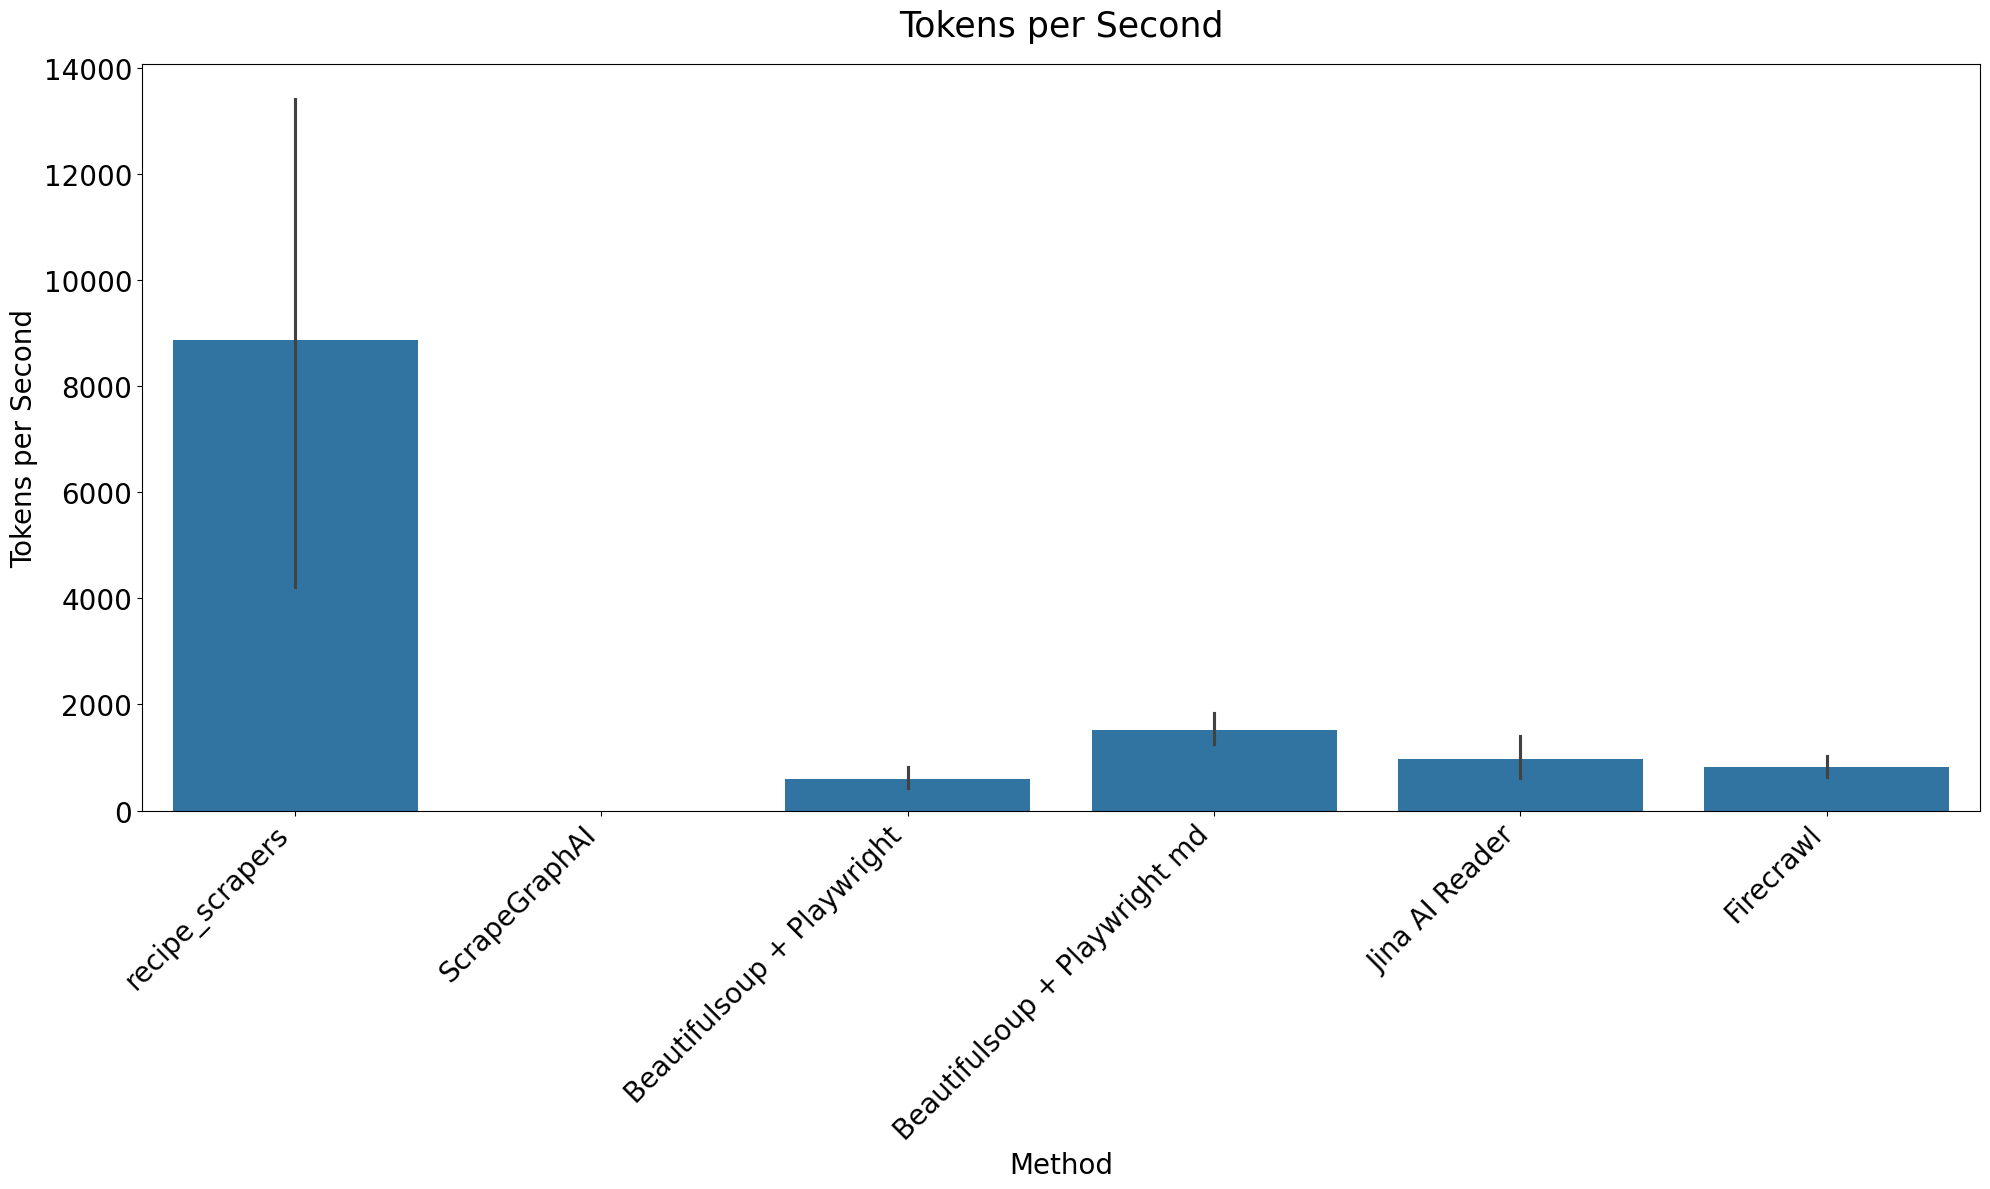

In [8]:
# Calculate efficiency metrics
efficiency_metrics = df.copy()
efficiency_metrics['tokens_per_second'] = (efficiency_metrics['input_tokens'] + efficiency_metrics['output_tokens']) / efficiency_metrics['time']
efficiency_summary = efficiency_metrics.groupby('method')['tokens_per_second'].mean().round(2)


# Create figure with larger size
plt.figure(figsize=(20, 12))

# Create bar plot
bar_plot = sns.barplot(
    data=efficiency_metrics,
    x='method',
    y='tokens_per_second',
)

# Customize the plot
plt.title('Tokens per Second', pad=20, fontsize=25)
plt.xlabel('Method', fontsize=20)
plt.ylabel('Tokens per Second', fontsize=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


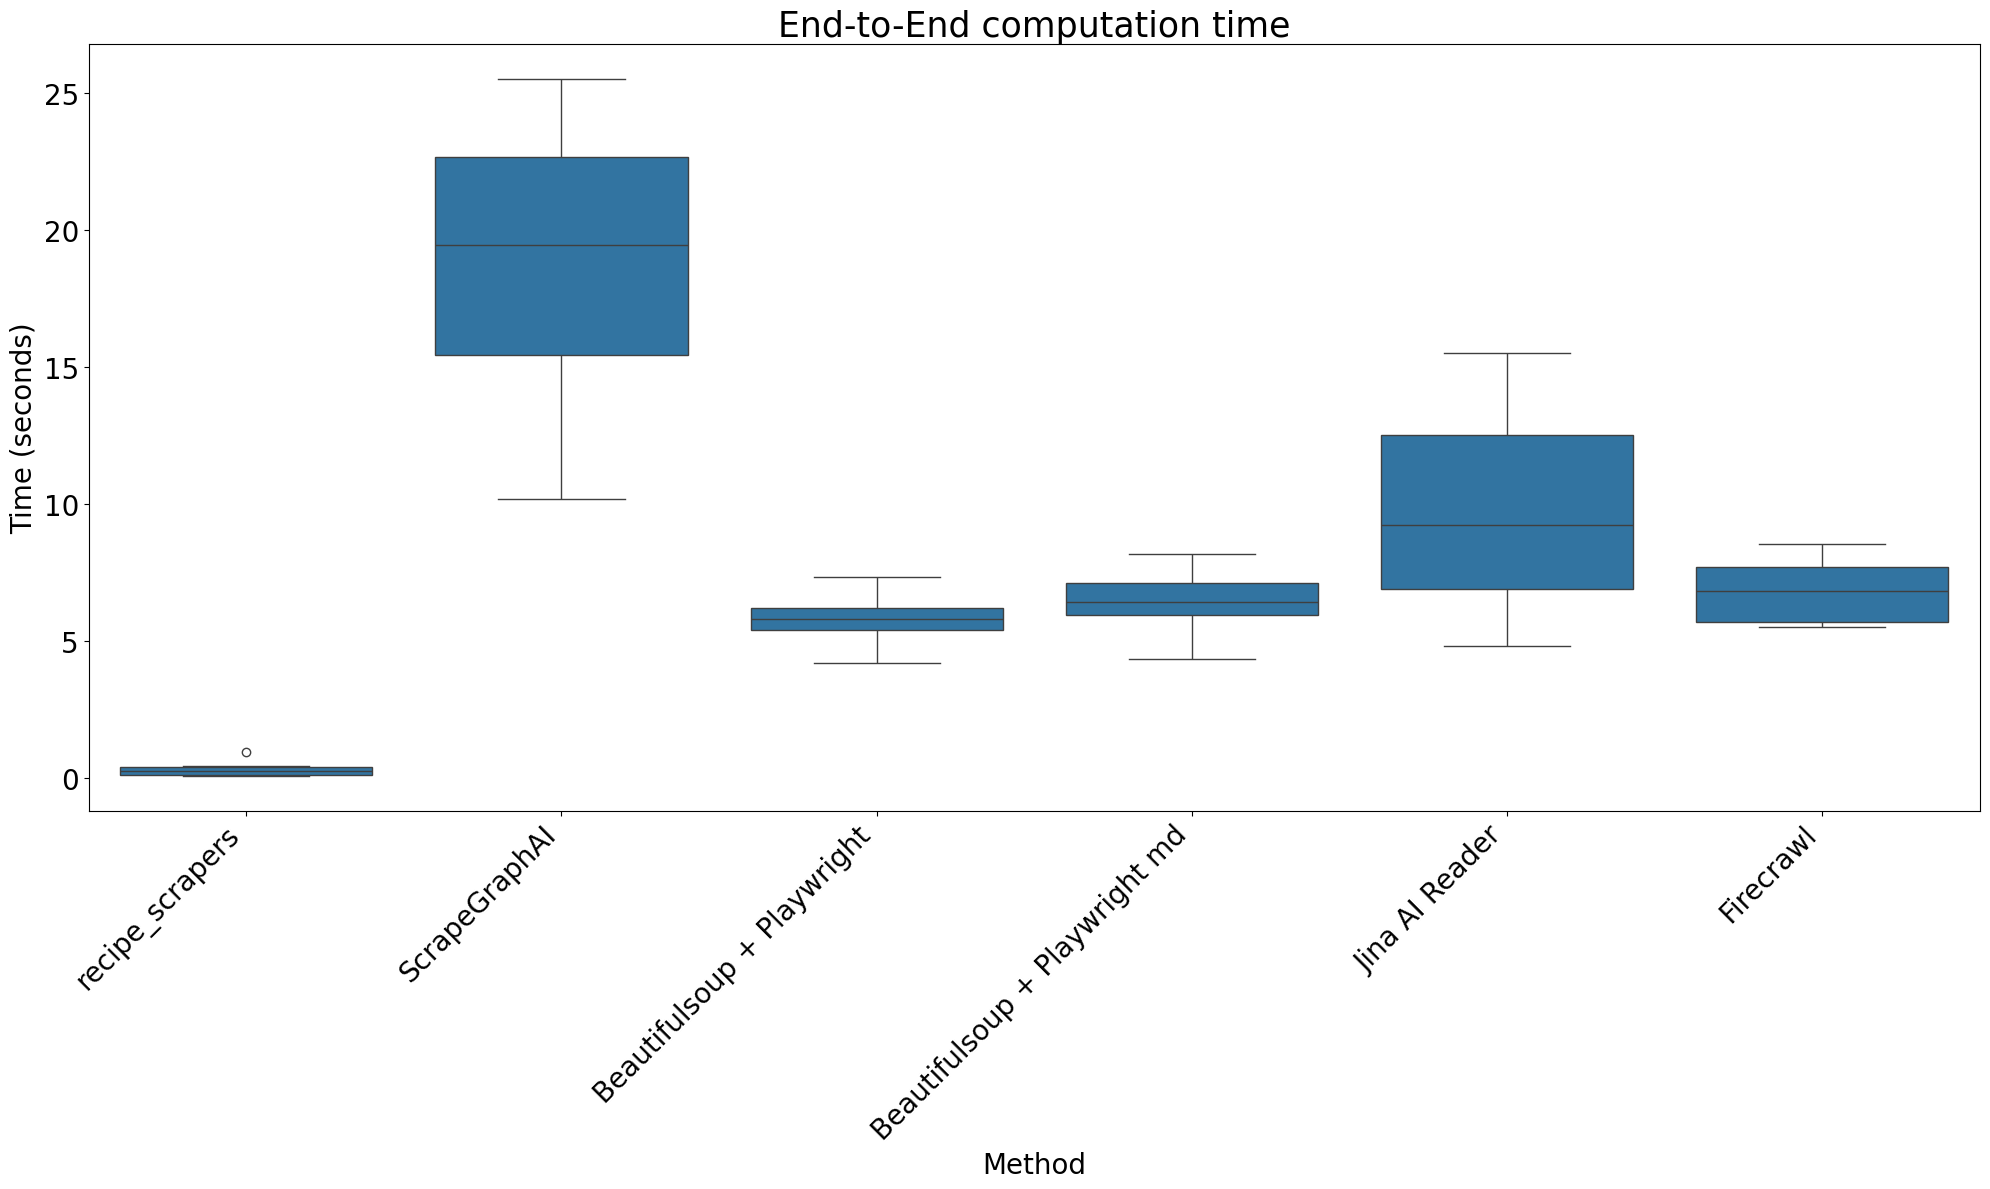

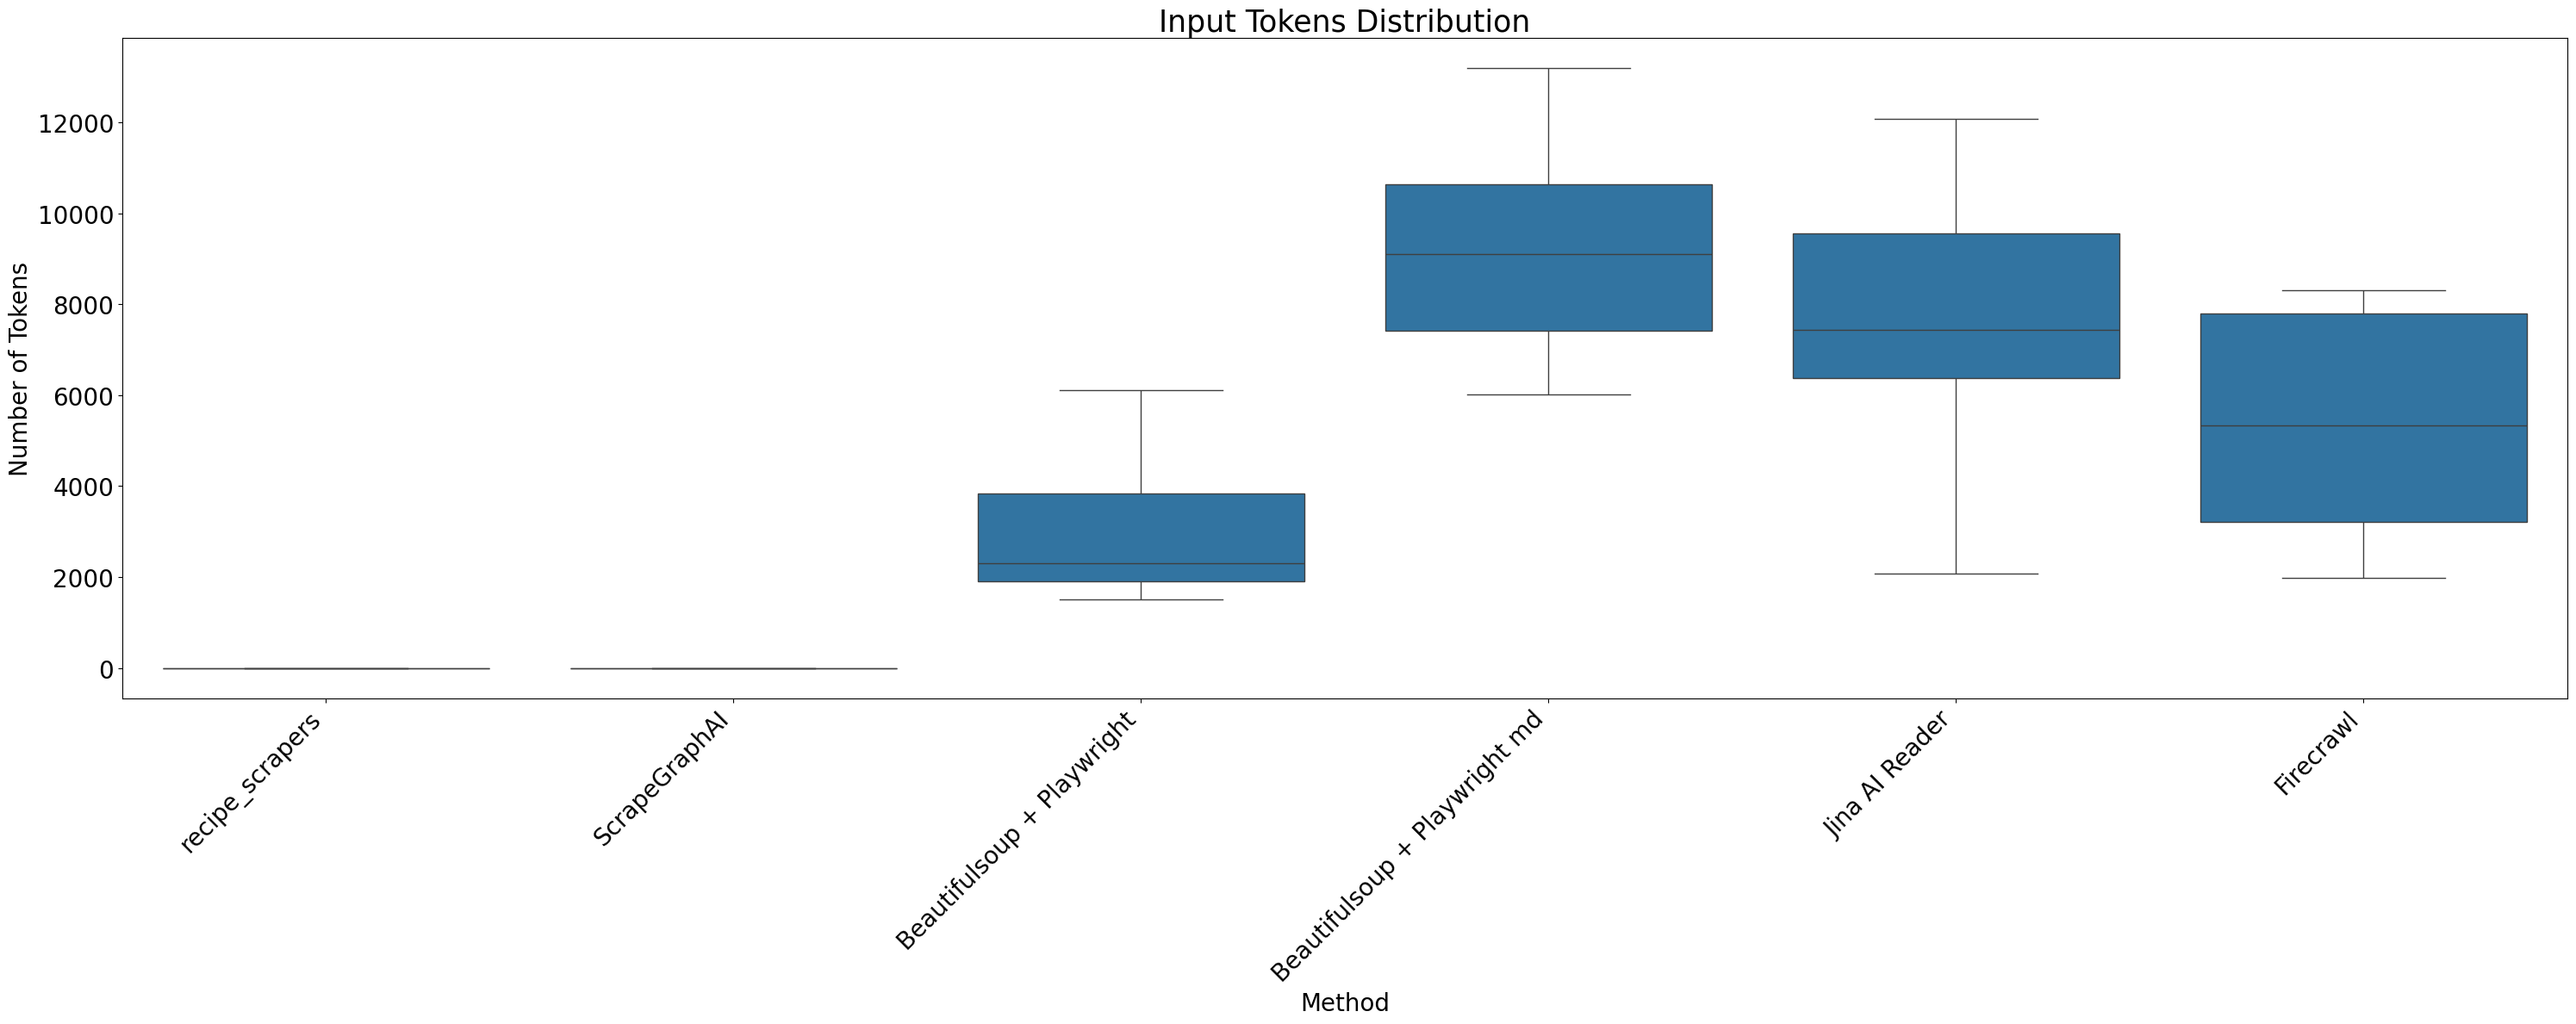

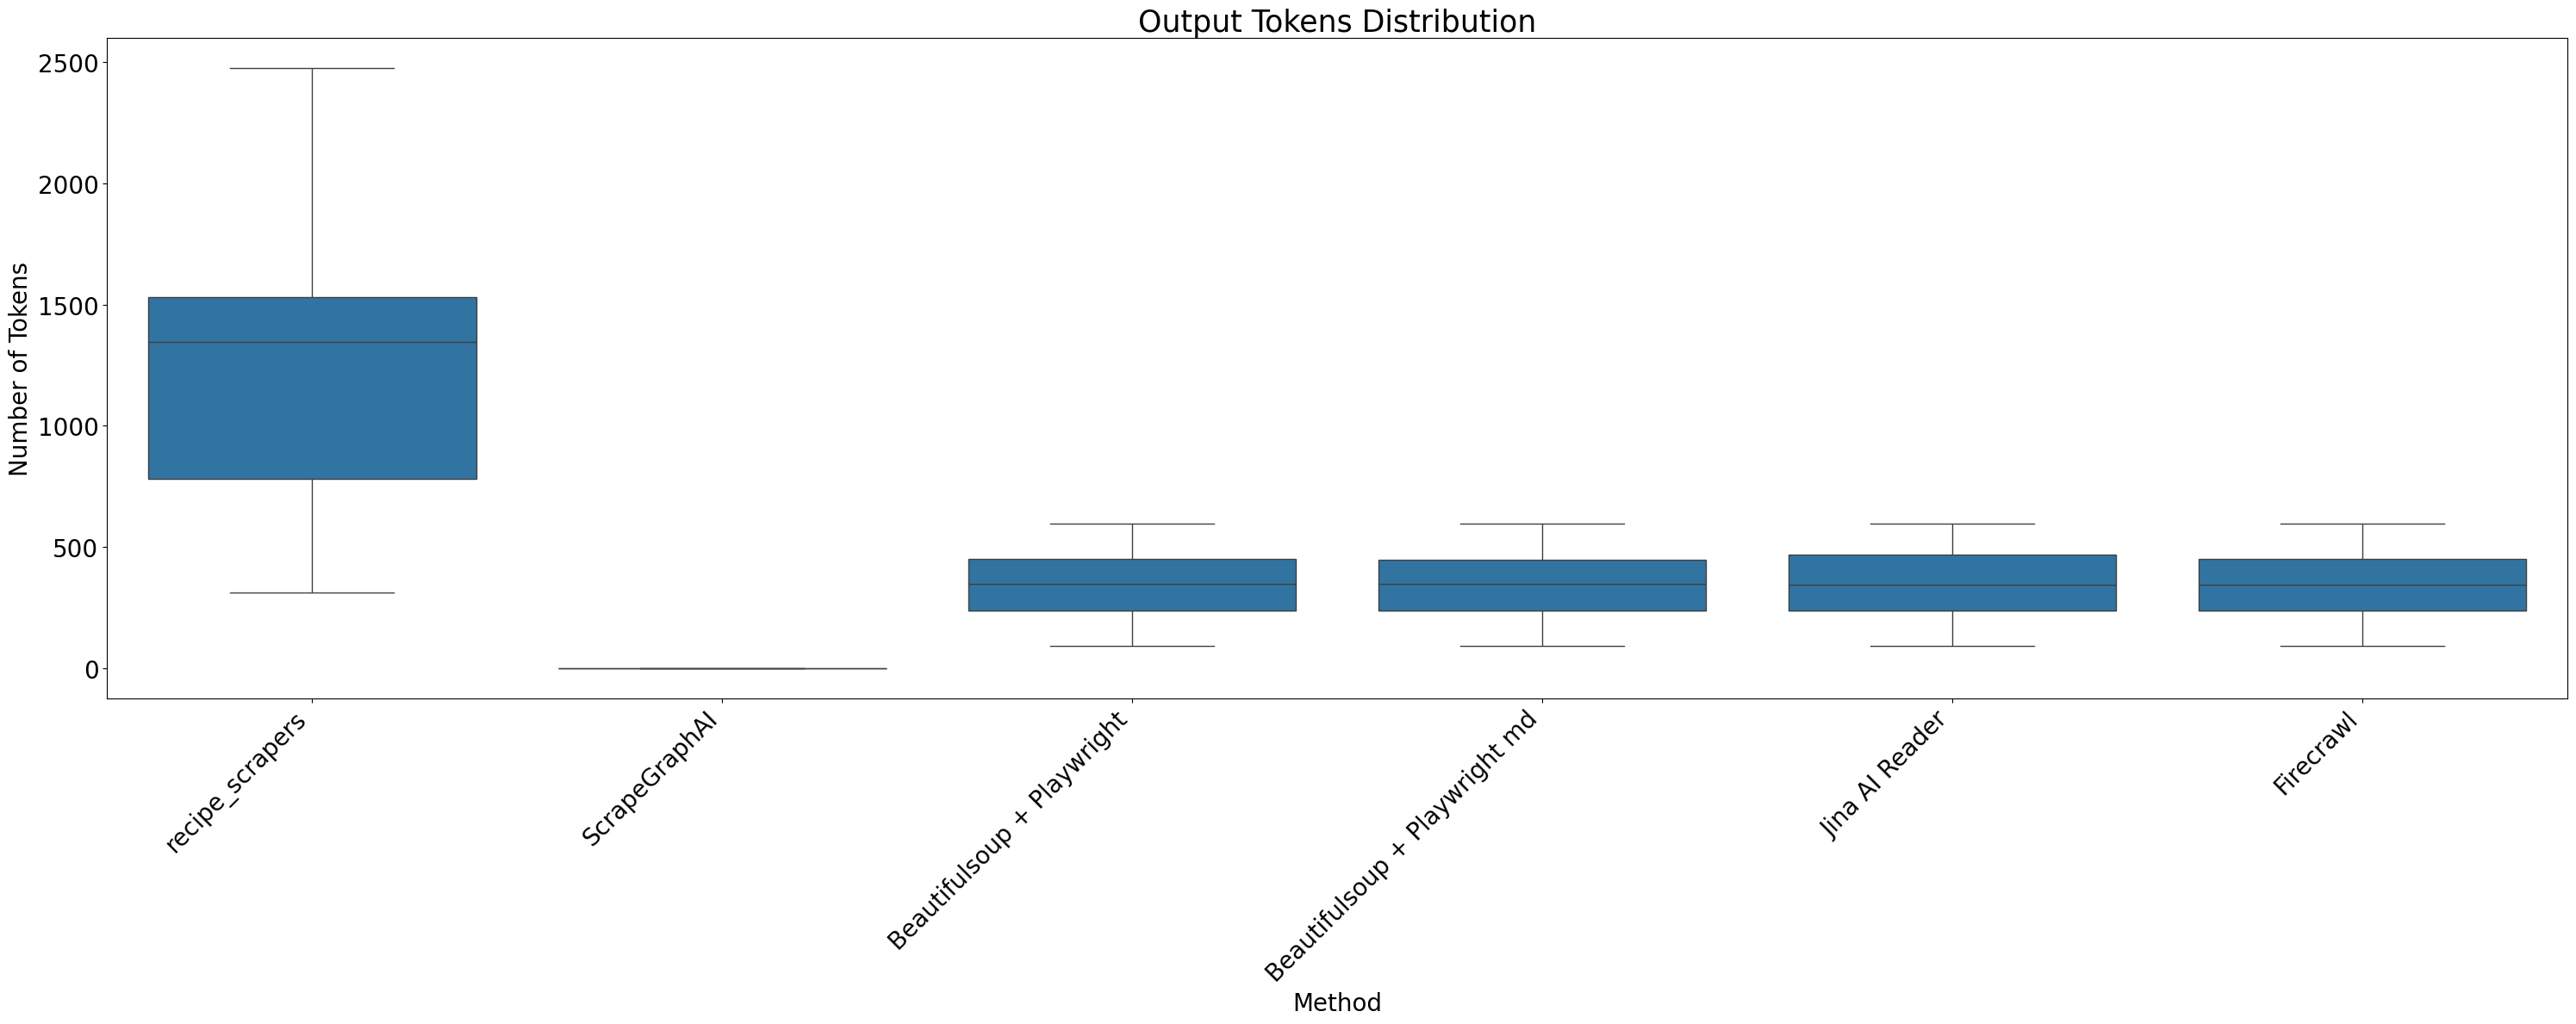

In [9]:
# 1. Processing Time Distribution
plt.figure(figsize=(20, 12))
sns.boxplot(data=df, x='method', y='time')
plt.title('End-to-End computation time', fontsize=25)
plt.xlabel('Method', fontsize=20)
plt.ylabel('Time (seconds)', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

# 2. Input Tokens Distribution
plt.figure(figsize=(30, 12))
sns.boxplot(data=df, x='method', y='input_tokens')
plt.title('Input Tokens Distribution', fontsize=25)
plt.xlabel('Method', fontsize=20)
plt.ylabel('Number of Tokens', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

# 3. Output Tokens Distribution
plt.figure(figsize=(30, 12))
sns.boxplot(data=df, x='method', y='output_tokens')
plt.title('Output Tokens Distribution', fontsize=25)
plt.xlabel('Method', fontsize=20)
plt.ylabel('Number of Tokens', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()


In [ ]:
#$0.075 / 1M input tokens
df['cost_output_tokens'] =  (df['output_tokens'] / 1_000_000) * 0.075

# $0.150 / 1M input tokens
df['cost_input_tokens'] =  (df['input_tokens'] / 1_000_000) * 0.150

# Calculate total cost
df['total_cost'] = df['cost_output_tokens'] + df['cost_input_tokens']


/var/folders/7z/7kg87r0908z_4ydpf7tq1pvw0000gn/T/ipykernel_28061/1547995872.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['total_cost'] = df[['total_cost', 'method']].apply(lambda x: 0 if x[1] == 'recipe_scrapers' else x[0], axis=1)
/var/folders/7z/7kg87r0908z_4ydpf7tq1pvw0000gn/T/ipykernel_28061/1547995872.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['cost_output_tokens'] = df[['cost_output_tokens', 'method']].apply(lambda x: 0 if x[1] == 'recipe_scrapers' else x[0], axis=1)
/var/folders/7z/7kg87r0908z_4ydpf7tq1pvw0000gn/T/ipykernel_28061/1547995872.py:12: FutureWarning: Series.__getitem__ treat

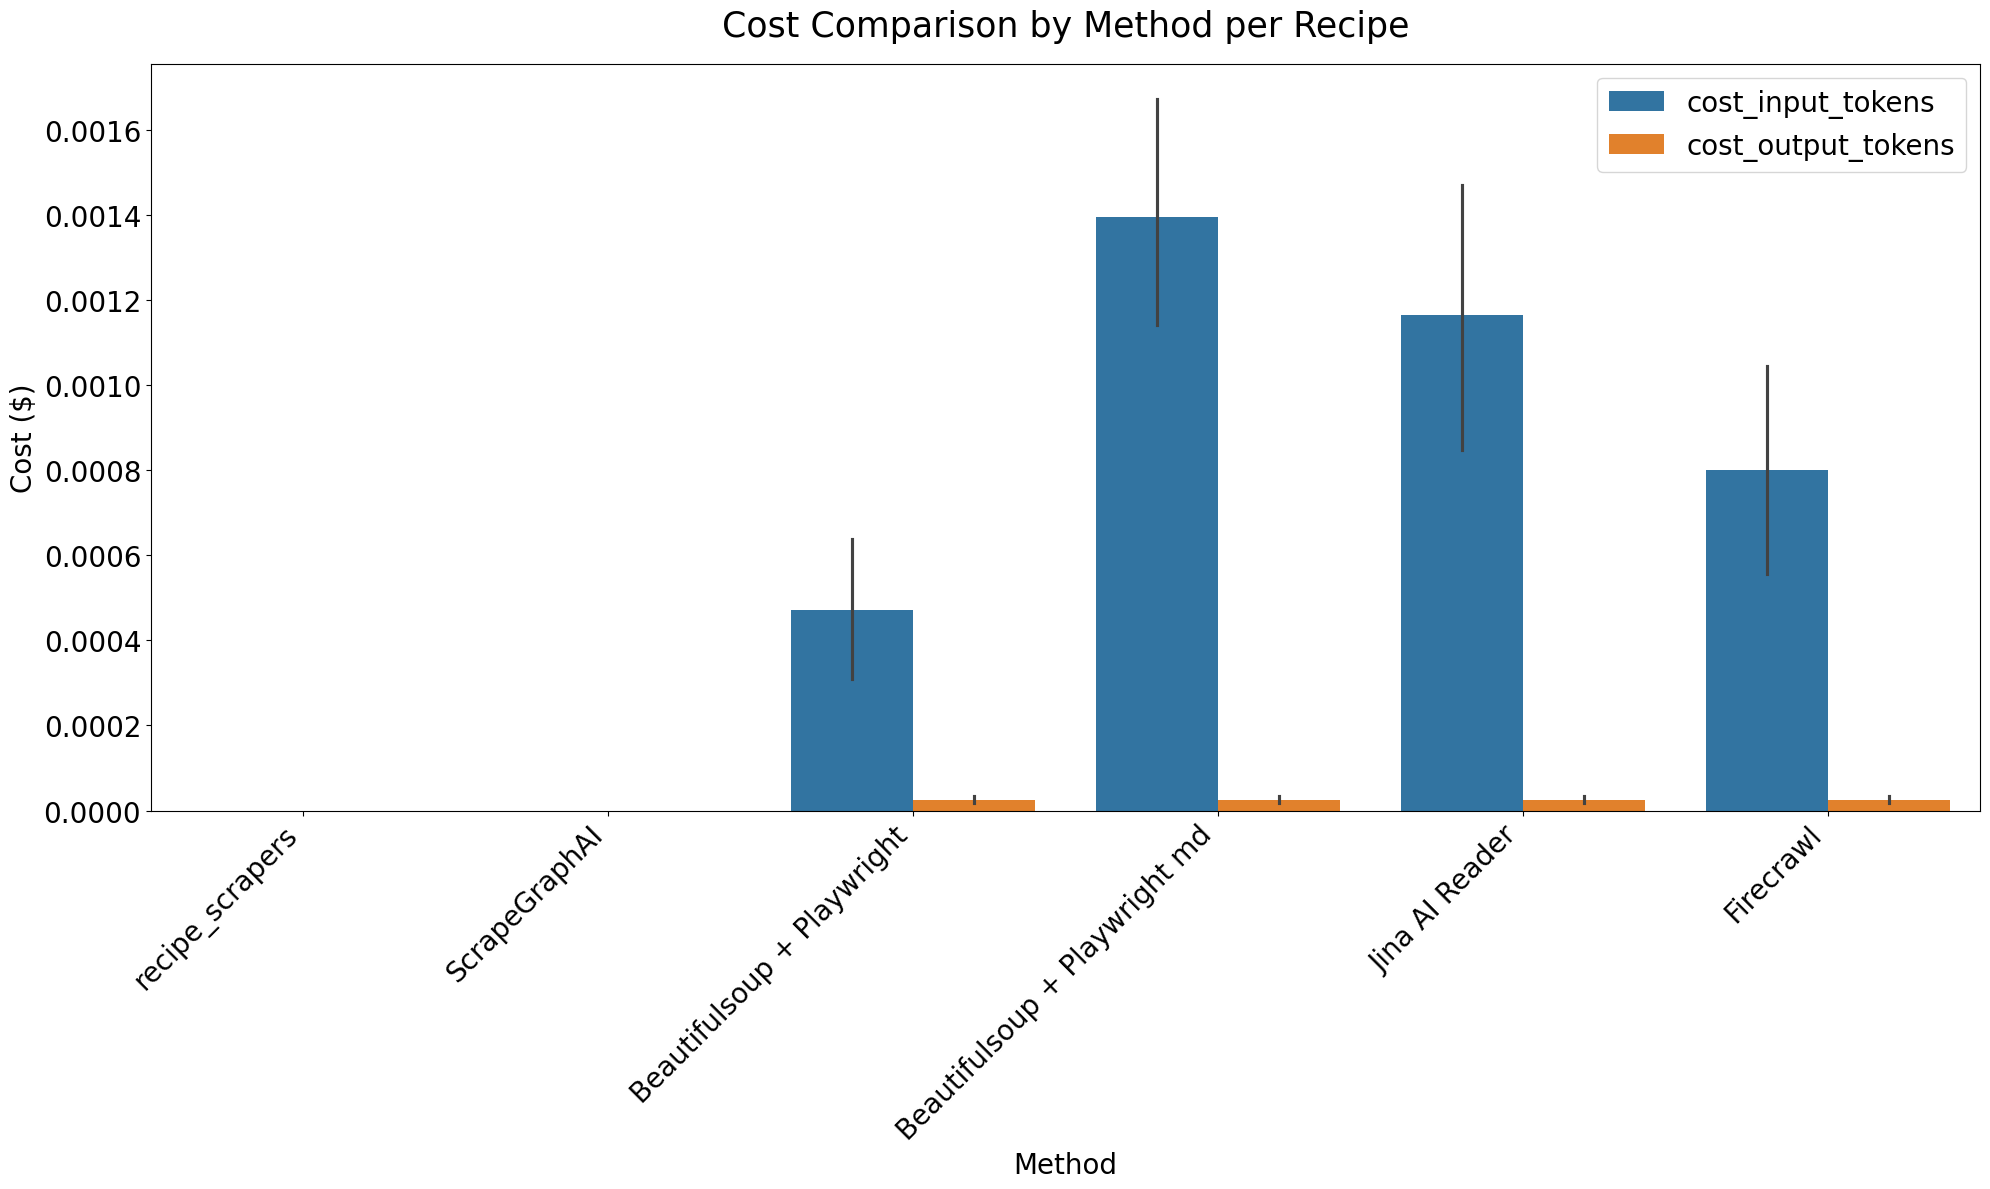

In [27]:
# Melt the DataFrame to get it into the right format for seaborn
df_melted = df.melt(
    id_vars=['method'],
    value_vars=['cost_input_tokens', 'cost_output_tokens'],
    var_name='cost_type',
    value_name='cost'
)

# Create the plot
plt.figure(figsize=(20, 12))

# Create grouped bar plot
ax = sns.barplot(
    data=df_melted,
    x='method',
    y='cost',
    hue='cost_type',
)

# Customize the plot
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.title('Cost Comparison by Method per Recipe', pad=20, fontsize=25)
plt.xlabel('Method', fontsize=20)
plt.ylabel('Cost ($)', fontsize=20)
plt.yticks(fontsize=20)

# Make legend bigger and more readable
plt.legend(
    fontsize=20,  # Increase font size
    title_fontsize=20,  # Increase title font size
)


# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()